In [1]:
import pybamm
pybamm.settings.heaviside_smoothing = 10
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
from scipy.optimize import root

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)
#notify=Audio(filename = "/home/drmrfc/Downloads/echoed-ding-459.mp3", autoplay = True)
########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

# data set when at office 
#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
# data set when at home

In [2]:
cap = 0.211

Ms = 32
F = 9.649e4

R = 8.3145
T = 298
ar = 0.960
I = cap*0.2#1.7
nu = 0.0114

#f_l = np.sqrt(nu*Ms/2)# (Ms*nu/2)**(1/2)
#f_m = np.sqrt(nu*Ms)#(4*Ms*nu)**(1/2)
#f_h = np.sqrt(nu*Ms)*2/(8**(1/4))#(16*Ms*nu)**(1/4)

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

ih0 = 5
im0 = 5
il0 = 5


S1_initial_cha = 1e-3
V_initial_cha = 2.0
I = -0.0211
def S2_func(S1):
    constant = np.exp((2*F/(R*T))*(V_initial_cha - (2*R*T/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

def S4_func(S2):
    constant = np.exp((2*F/(R*T))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

def S8_func(S4):
    constant = np.exp((4*F/(R*T))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

S2_initial_cha = S2_func(S1_initial_cha)
S4_initial_cha = S4_func(S2_initial_cha)
S8_initial_cha = S8_func(S4_initial_cha)
print(S1_initial_cha)
print(S2_initial_cha)
print(S4_initial_cha)
print(S8_initial_cha)


EH = EH0 + (R*T)*np.log(f_h*(S8_initial_cha**(1/4))/(S4_initial_cha**(1/2)))/(F)
eta_H = V_initial_cha - EH
iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))
print('EH initial')
print(EH)
print('eta_H initial')
print(eta_H)
print('iH initial')
print(iH)

EM = EM0 + (R*T)*np.log(f_m*(S4_initial_cha**(1/2))/S2_initial_cha)/(F)
eta_M = V_initial_cha - EM
iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))
print('EM initial')
print(EM)
print('eta_M initial')
print(eta_M)
print('iM initial')
print(iM)

EL = EL0 + (R*T/F)*np.log(f_l*(S2_initial_cha**(1/2))/S1_initial_cha)
eta_L = V_initial_cha - EL
iL = -2*il0*ar*np.sinh(F*eta_L/(2*R*T))
print('EL initial')
print(EL)
print('eta_L initial')
print(eta_L)
print('iL initial')
print(iL)

0.001
0.013113145894720814
6.38122975361841e-18
4.5372721447883005e-64
EH initial
2.0
eta_H initial
0.0
iH initial
-0.0
EM initial
2.0
eta_M initial
0.0
iM initial
-0.0
EL initial
1.9998871215691447
eta_L initial
0.00011287843085527882
iL initial
-0.021100000000008695


In [3]:
Sp_initial_cha = .43
S_star = 1e-6#S1_initial_cha*0.01
kp = 5000
print(S_star)
(2 * Ms * iL / (1 * F)) - kp * Sp_initial_cha * (S1_initial_cha - S_star) / (nu * 2000)

1e-06


-0.09421794260108765

In [55]:
model_cha1 = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_cha1 = model_cha1.default_parameter_values
param_cha1.update(
    {
        "Current function [A]": -.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha,
        "Initial Condition for S4 ion [g]" : S4_initial_cha,
        "Initial Condition for S2 ion [g]" : S2_initial_cha,
        "Initial Condition for S ion [g]" : S1_initial_cha,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        
        }
)


sim_cha1 = pybamm.Simulation(
    model_cha1,
    #experiment=experiment,
    parameter_values = param_cha1,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = int(3600*(0.25/0.0211))#.67*7000#16950#3600*hours
for i in range(0,time_in_seconds):
    if i % 1000 == 0 :
           print('\n\n\n\n' + str(100*i/time_in_seconds) + '\n\n\n\n')
    try:
        sim_cha1.step(1)
    except:
        break
        
        
print('\n\n\n\n\n\n\n\n\n done')





0.0






psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed






2.3444460074084494








4.688892014816899








7.033338022225348








9.377784029633798








11.722230037042246








14.066676044450697








16.411122051859145








18.755568059267596








21.100014066676046








23.444460074084493








25.788906081492943








28.133352088901393








30.477798096309844








32.82224410371829








35.16669011112674








37.51113611853519








39.85558212594364








42.20002813335209








44.544474140760535








46.888920148168985








49.233366155577436








51.577812162985886








53.922258170394336








56.26670417780279








58.61115018521124








60.95559619261969








63.30004220002813








65.64448820743658








67.98893421484503








70.33338022225348








72.67782622966193








75.02227223707038








77.36671824447883








79.71116425188728








82.05561025929573








84.40005626670418








86.74450227411263








89.08894828152107



Text(0, 0.5, 'Voltage [V]')

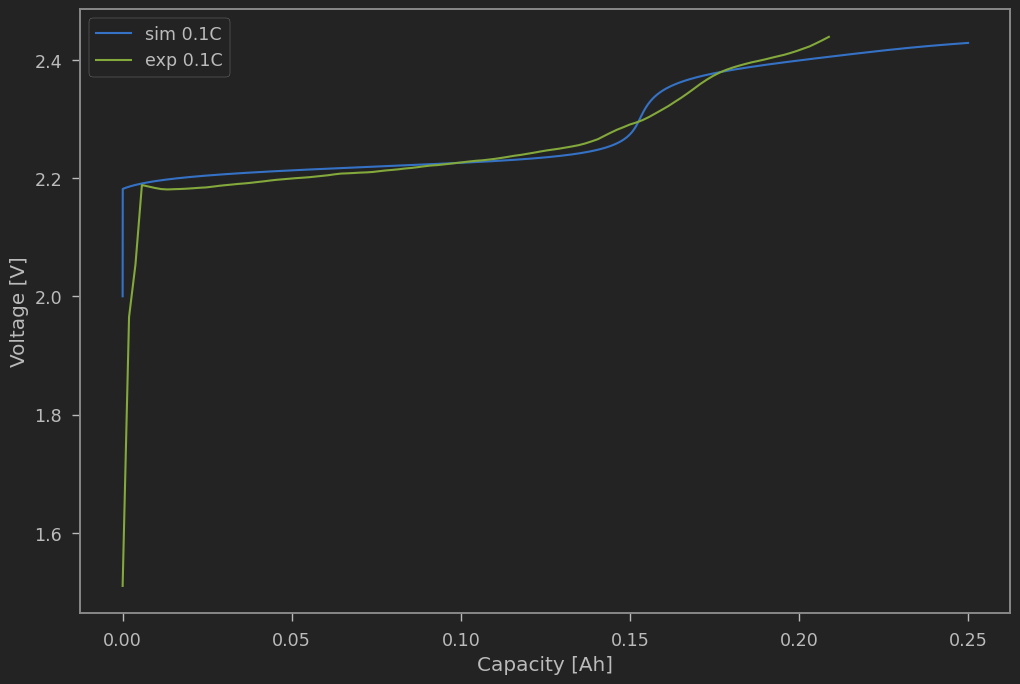

In [56]:
loc = -1
capacity = 0.0211*sim_cha1.solution.t[:loc]/3600
V = sim_cha1.solution["Terminal voltage [V]"].entries[:loc]
plt.plot(capacity, V)


# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C", "exp 0.1C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

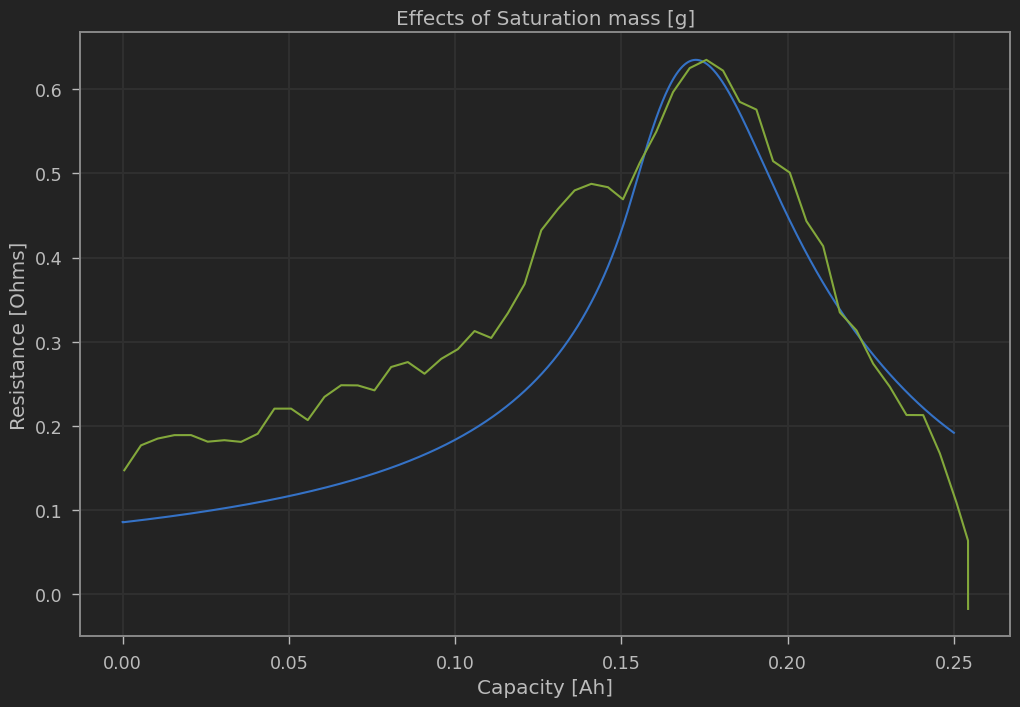

In [57]:
capacity = .0211*sim_cha1.solution.t/3600
S4 = sim_cha1.solution['S4 [g]'].entries
S2 = sim_cha1.solution['S2 [g]'].entries
S1 = sim_cha1.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 

filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

sigma_0 = max(Li)*1.15
R = 1/(sigma_0-Li)
alpha = max(res_charge_data['30'][1])/max(R)
R *= alpha

plt.plot(capacity,R)

plt.plot(res_charge_data['30'][0],res_charge_data['30'][1])

plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)

In [58]:
loc = -1
S1_initial = sim_cha1.solution['S [g]'].entries[loc]
S2_initial = sim_cha1.solution['S2 [g]'].entries[loc]
S4_initial = sim_cha1.solution['S4 [g]'].entries[loc]
S8_initial = sim_cha1.solution['S8 [g]'].entries[loc]
Sp_initial = sim_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_cha1.solution['Terminal voltage [V]'].entries[loc]
cap_temp = sim_cha1.solution.t[loc]*0.0221/3600
print(S8_initial)
print(S4_initial)
print(S2_initial)
print(S1_initial)
print(Sp_initial)
print(V_initial)
print(cap_temp)

0.06287093493673725
0.23714555113093122
0.14233884619713208
1.8311566258783464e-10
0.0017578134467974714
2.4288945456189097
0.26184816666666666


In [59]:
model_dis1 = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_dis1 = model_dis1.default_parameter_values
param_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        #'Shuttle rate coefficient during charge [s-1]': 0.00001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 100,
        #'Reference Temperature [K]': 298
        
        }
)



experiment = pybamm.Experiment(
    [
        ("Discharge at 0.0422 A for 2 hours or until 2.0 V"),
    ] 
)


sim_dis1 = pybamm.Simulation(
    model_dis1,
    #experiment=experiment,
    parameter_values = param_dis1,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8

time_in_seconds = int(3600*(0.2534/0.0422))#.67*7000#16950#3600*hours
for i in range(0,time_in_seconds):
    if i % 1000 == 0 :
           print('\n\n\n\n' + str(100*i/time_in_seconds) + '\n\n\n\n')
    try:
        sim_dis1.step(1)
    except:
        break
        
        
print('\n\n\n\n\n\n\n\n\n done')





0.0








4.688892014816899








9.377784029633798








14.066676044450697








18.755568059267596






psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 5889.08 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 5890.41 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 5892 and h = 





23.444460074084493








28.133352088901393








32.82224410371829








37.51113611853519








42.20002813335209








46.888920148168985








51.577812162985886








56.26670417780279








60.95559619261969








65.64448820743658








70.33338022225348








75.02227223707038








79.71116425188728








84.40005626670418








89.08894828152107








93.77784029633797








98.46673231115487













 done


Text(0, 0.5, 'Voltage [V]')

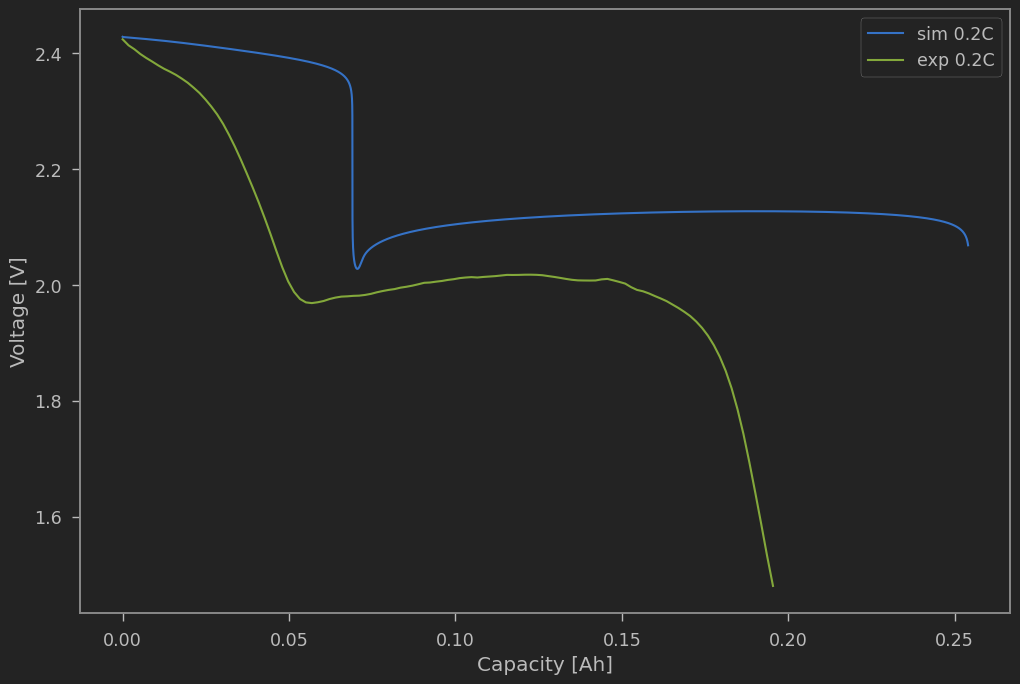

In [66]:
plt.plot(sim_dis1.solution.t*0.0422/3600, sim_dis1.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.legend(["sim 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

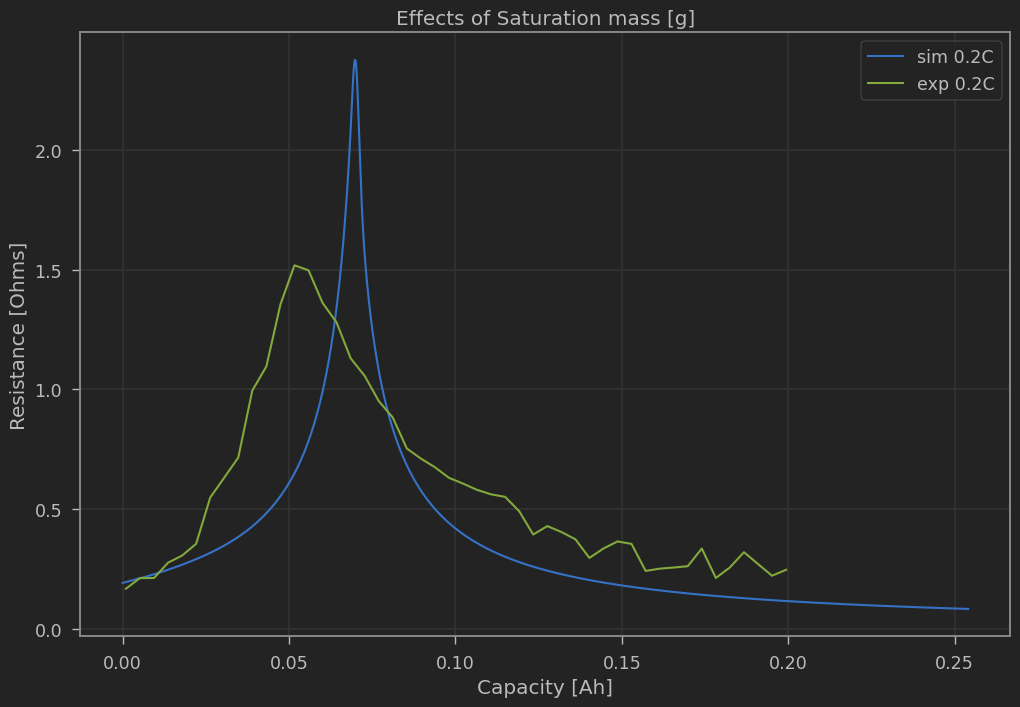

In [67]:
capacity = 2*.0211*sim_dis1.solution.t/3600
S4 = sim_dis1.solution['S4 [g]'].entries
S2 = sim_dis1.solution['S2 [g]'].entries
S1 = sim_dis1.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 
R = alpha/(sigma_0-Li)
plt.plot(capacity, R)

filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(res_discharge_data['30'][0],res_discharge_data['30'][1])

#plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)
plt.legend(["sim 0.2C","exp 0.2C" ])

In [69]:
loc = -1
S1_initial = sim_dis1.solution['S [g]'].entries[loc]
S2_initial = sim_dis1.solution['S2 [g]'].entries[loc]
S4_initial = sim_dis1.solution['S4 [g]'].entries[loc]
S8_initial = sim_dis1.solution['S8 [g]'].entries[loc]
Sp_initial = sim_dis1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_dis1.solution['Terminal voltage [V]'].entries[loc]
cap_temp = sim_dis1.solution.t[loc]*0.0221/3600
print(S8_initial)
print(S4_initial)
print(S2_initial)
print(S1_initial)
print(Sp_initial)
print(V_initial)
print(cap_temp)

7.18633462876551e-60
3.862334073527993e-18
0.0007074927291388826
1.5394411988468652e-05
0.44339025875366894
2.0685106752311353
0.13301744444444447


In [71]:
model_cha2 = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_cha2 = model_cha1.default_parameter_values
param_cha2.update(
    {
        "Current function [A]": -.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        
        }
)


sim_cha2 = pybamm.Simulation(
    model_cha2,
    #experiment=experiment,
    parameter_values = param_cha2,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = int(3600*(0.25/0.0211))#.67*7000#16950#3600*hours
for i in range(0,time_in_seconds):
    if i % 1000 == 0 :
           print('\n\n\n\n' + str(100*i/time_in_seconds) + '\n\n\n\n')
    try:
        sim_cha2.step(1)
    except:
        break
        
        
print('\n\n\n\n\n\n\n\n\n done')





0.0








2.3444460074084494








4.688892014816899








7.033338022225348








9.377784029633798








11.722230037042246








14.066676044450697








16.411122051859145








18.755568059267596








21.100014066676046








23.444460074084493








25.788906081492943








28.133352088901393








30.477798096309844








32.82224410371829








35.16669011112674








37.51113611853519








39.85558212594364








42.20002813335209








44.544474140760535








46.888920148168985








49.233366155577436








51.577812162985886








53.922258170394336








56.26670417780279








58.61115018521124








60.95559619261969








63.30004220002813








65.64448820743658








67.98893421484503








70.33338022225348








72.67782622966193








75.02227223707038








77.36671824447883








79.71116425188728








82.05561025929573








84.40005626670418








86.74450227411263








89.0889

Text(0, 0.5, 'Voltage [V]')

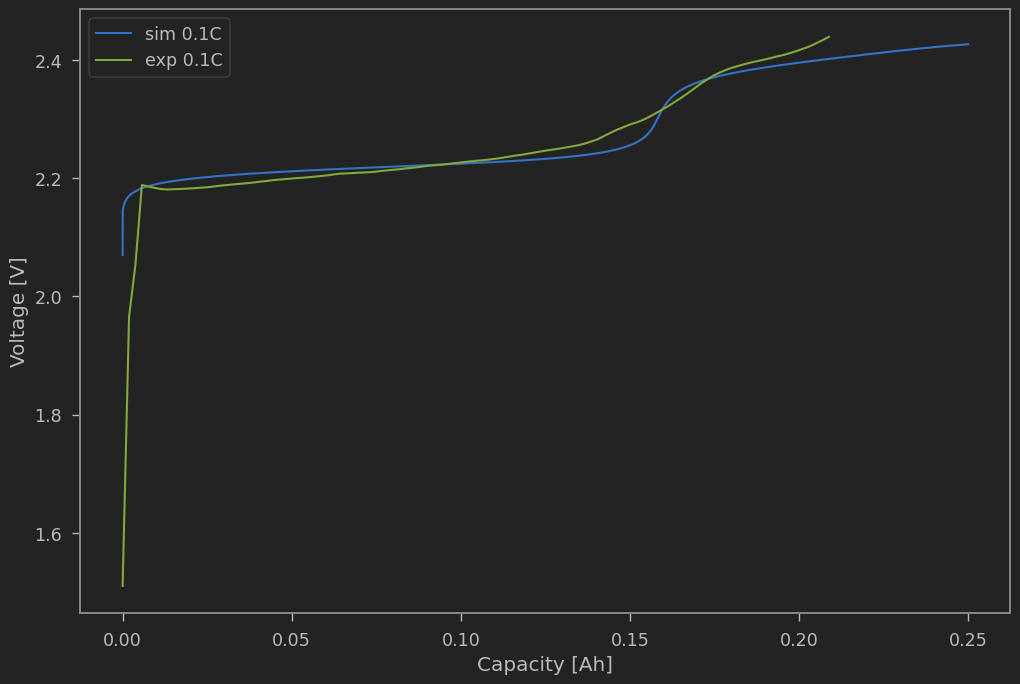

In [72]:
loc = -1
capacity = 0.0211*sim_cha2.solution.t[:loc]/3600
V = sim_cha2.solution["Terminal voltage [V]"].entries[:loc]
plt.plot(capacity, V)


# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C", "exp 0.1C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

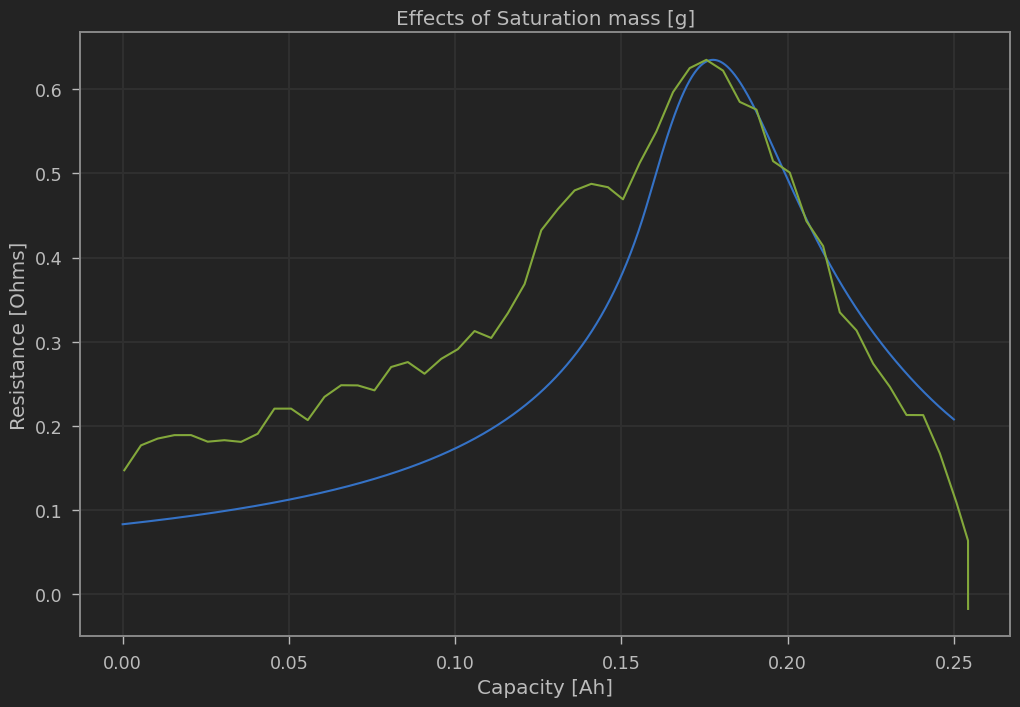

In [73]:
capacity = .0211*sim_cha2.solution.t/3600
S4 = sim_cha2.solution['S4 [g]'].entries
S2 = sim_cha2.solution['S2 [g]'].entries
S1 = sim_cha2.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 

filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

R = alpha/(sigma_0-Li)

plt.plot(capacity,R)

plt.plot(res_charge_data['30'][0],res_charge_data['30'][1])

plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)

In [117]:
loc = -3000
S1_initial = sim_cha2.solution['S [g]'].entries[loc]
S2_initial = sim_cha2.solution['S2 [g]'].entries[loc]
S4_initial = sim_cha2.solution['S4 [g]'].entries[loc]
S8_initial = sim_cha2.solution['S8 [g]'].entries[loc]
Sp_initial = sim_cha2.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_cha2.solution['Terminal voltage [V]'].entries[loc]
cap_temp = sim_cha2.solution.t[loc]*0.0221/3600
print(S8_initial)
print(S4_initial)
print(S2_initial)
print(S1_initial)
print(Sp_initial)
print(V_initial)
print(cap_temp)

0.00915084712665951
0.21737174533818587
0.21347032345819483
3.4978896460088037e-10
0.004120229621967443
2.417495645786875
0.24343763888888892


In [118]:
model_dis2 = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_dis2 = model_dis1.default_parameter_values
param_dis2.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        #'Shuttle rate coefficient during charge [s-1]': 0.00001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 50,
        #'Reference Temperature [K]': 298
        
        }
)



experiment = pybamm.Experiment(
    [
        ("Discharge at 0.0422 A for 2 hours or until 2.0 V"),
    ] 
)


sim_dis2 = pybamm.Simulation(
    model_dis2,
    #experiment=experiment,
    parameter_values = param_dis2,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8

time_in_seconds = int(3600*(0.2534/0.0422))#.67*7000#16950#3600*hours
'''
for i in range(0,time_in_seconds):
    if i % 1000 == 0 :
           print('\n\n\n\n' + str(100*i/time_in_seconds) + '\n\n\n\n')
    try:
        sim_dis2.step(10)
    except:
        break
        
'''
sim_dis2.step(4100)
time = 4100
while time < time_in_seconds:
    try:
        sim_dis2.step(5)
        time+= 5
    except:
        try: 
            sim_dis2.step(1)
            time += 1
        except:
            break
print('\n\n\n\n\n\n\n\n\n done')

At t = 999.038, , mxstep steps taken before reaching tout.
At t = 999.038, , mxstep steps taken before reaching tout.
At t = 999.038, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/su

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19755.5 and h = 1.49012e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19767.6 and h = 7.34872e-14, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19818.3 and h = 9.53674e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19821.5 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19841 and h =

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19844.3 and h = 5.6034e-13, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../










 done


.../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19844.3 and h = 1.75103e-14,

Text(0, 0.5, 'Voltage [V]')

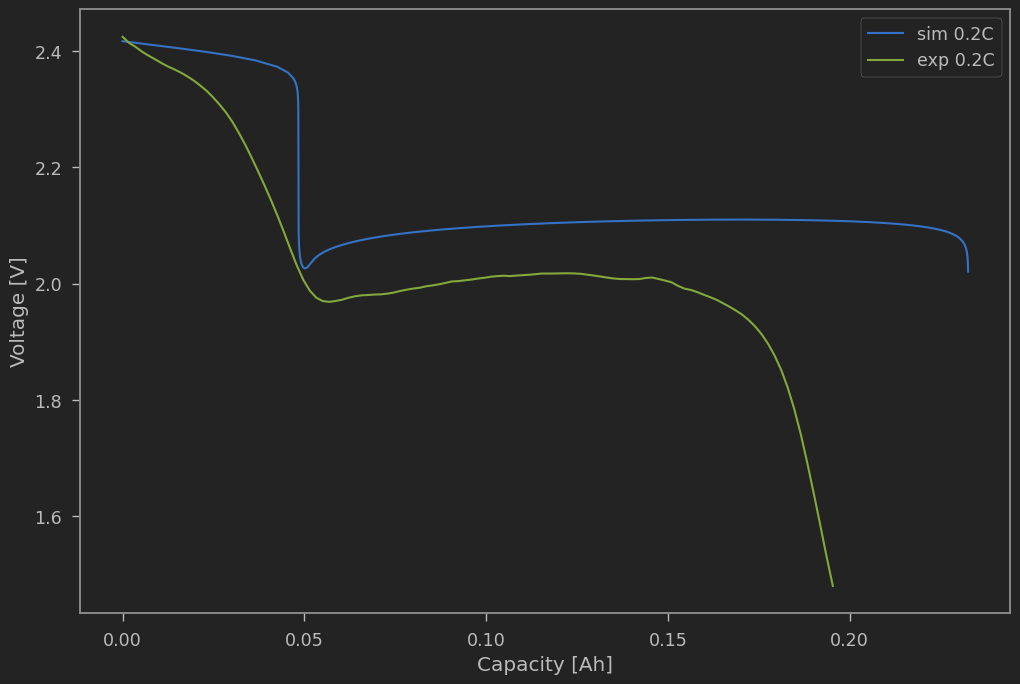

In [119]:
plt.plot(sim_dis2.solution.t*0.0422/3600, sim_dis2.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.legend(["sim 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

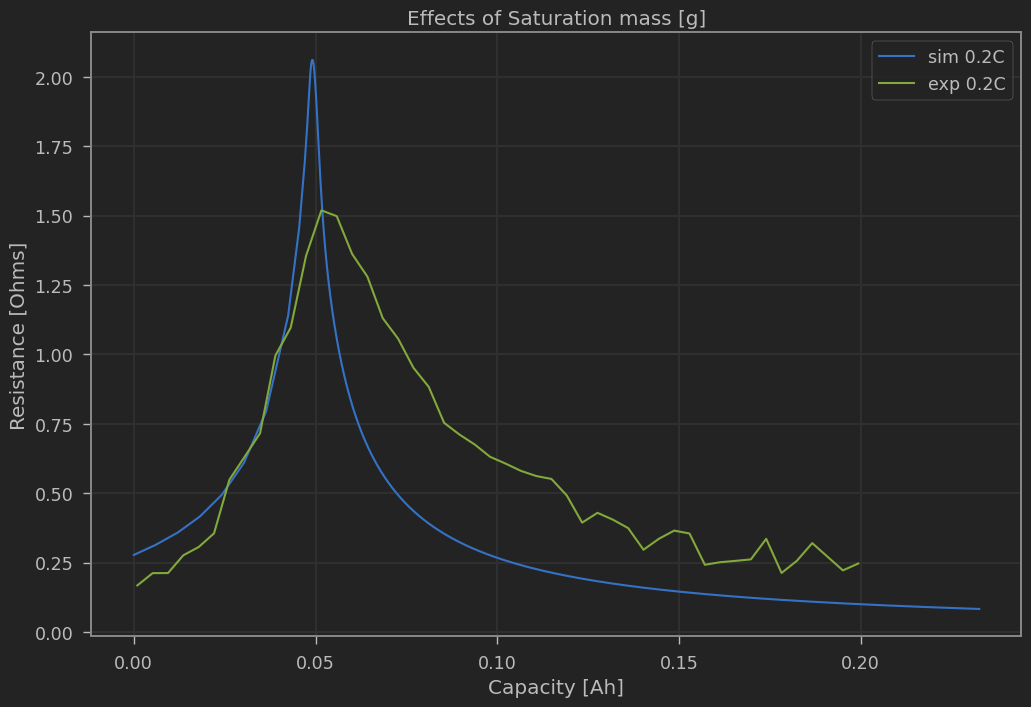

In [120]:
capacity = 2*.0211*sim_dis2.solution.t/3600
S4 = sim_dis2.solution['S4 [g]'].entries
S2 = sim_dis2.solution['S2 [g]'].entries
S1 = sim_dis2.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 
R = alpha/(sigma_0-Li)
plt.plot(capacity, R)

filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(res_discharge_data['30'][0],res_discharge_data['30'][1])

#plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)
plt.legend(["sim 0.2C","exp 0.2C" ])

In [121]:
sim_cha_list = [sim_cha1, sim_cha2]
sim_dis_list = [sim_dis1, sim_dis2]

In [122]:
sim_dis = sim_dis_list[-1]

loc = -1
S1_initial = sim_dis.solution['S [g]'].entries[loc]
S2_initial = sim_dis.solution['S2 [g]'].entries[loc]
S4_initial = sim_dis.solution['S4 [g]'].entries[loc]
S8_initial = sim_dis.solution['S8 [g]'].entries[loc]
Sp_initial = sim_dis.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_dis.solution['Terminal voltage [V]'].entries[loc]

model_cha = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_cha = model_cha.default_parameter_values
param_cha.update(
    {
        "Current function [A]": -.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        
        }
)


sim_cha = pybamm.Simulation(
    model_cha,
    #experiment=experiment,
    parameter_values = param_cha,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = int(3600*(0.25/0.0211))#.67*7000#16950#3600*hours
for i in range(0,time_in_seconds):
    if i % 1000 == 0 :
           print('\n\n\n\n' + str(100*i/time_in_seconds) + '\n\n\n\n')
    try:
        sim_cha.step(1)
    except:
        break
        
        
print('\n\n\n\n\n\n\n\n\n done')





0.0






psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





2.3444460074084494








4.688892014816899








7.033338022225348








9.377784029633798








11.722230037042246








14.066676044450697








16.411122051859145








18.755568059267596








21.100014066676046








23.444460074084493








25.788906081492943








28.133352088901393








30.477798096309844








32.82224410371829








35.16669011112674








37.51113611853519








39.85558212594364








42.20002813335209








44.544474140760535








46.888920148168985








49.233366155577436








51.577812162985886








53.922258170394336








56.26670417780279








58.61115018521124








60.95559619261969








63.30004220002813








65.64448820743658








67.98893421484503








70.33338022225348








72.67782622966193








75.02227223707038








77.36671824447883








79.71116425188728








82.05561025929573








84.40005626670418








86.74450227411263








89.08894828152107



Text(0, 0.5, 'Voltage [V]')

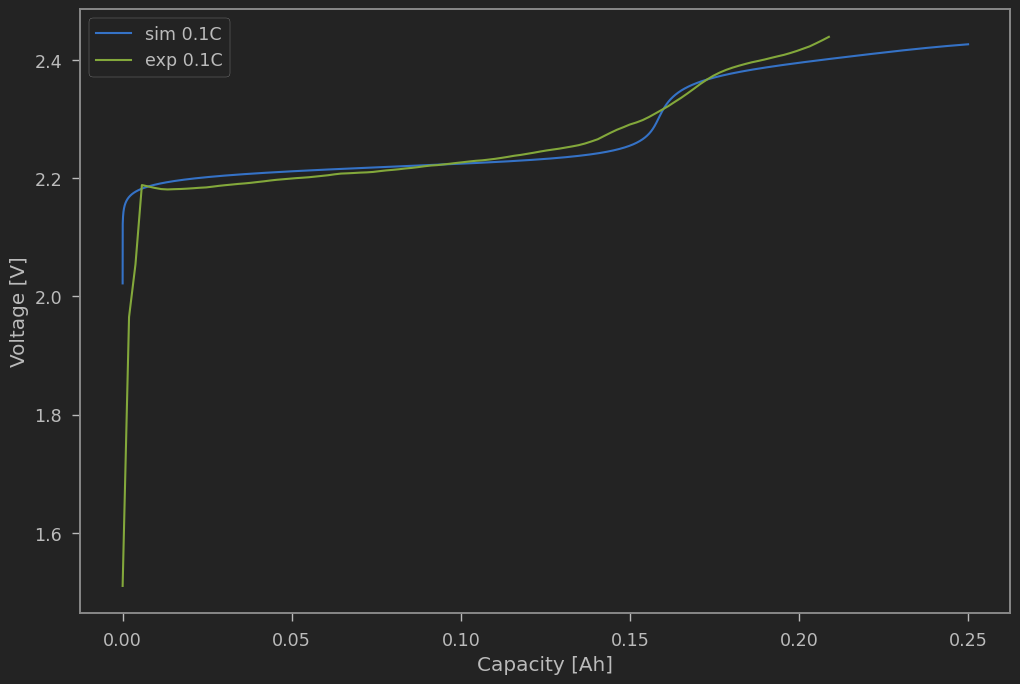

In [123]:
loc = -1
capacity = 0.0211*sim_cha.solution.t[:loc]/3600
V = sim_cha.solution["Terminal voltage [V]"].entries[:loc]
plt.plot(capacity, V)


# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C", "exp 0.1C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

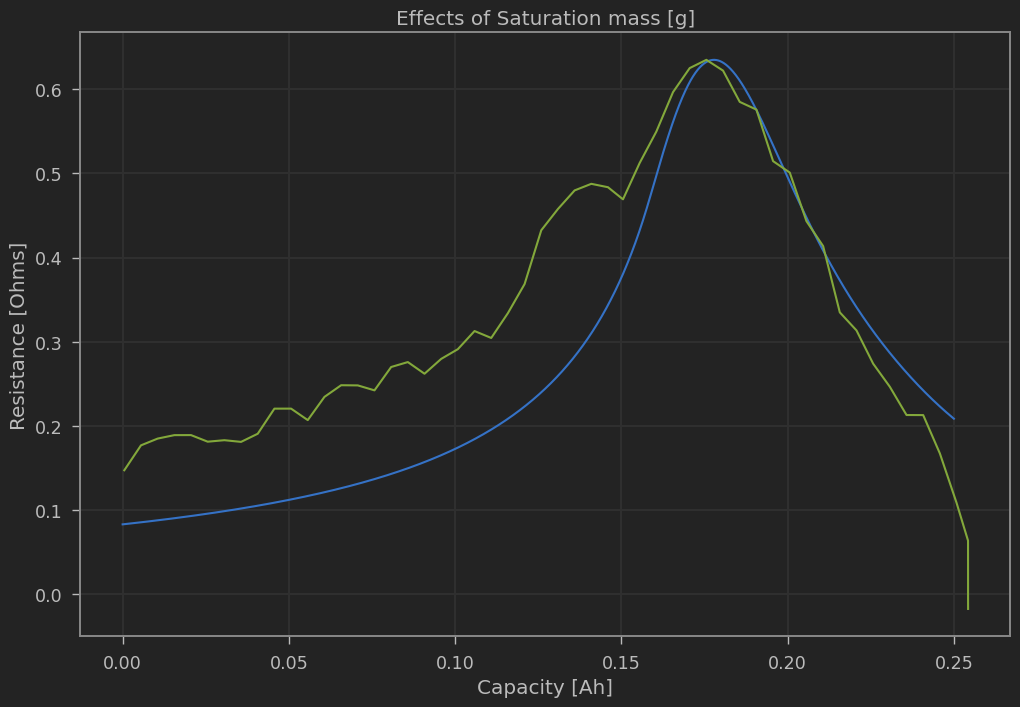

In [124]:
capacity = .0211*sim_cha.solution.t/3600
S4 = sim_cha.solution['S4 [g]'].entries
S2 = sim_cha.solution['S2 [g]'].entries
S1 = sim_cha.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 

filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

R = alpha/(sigma_0-Li)

plt.plot(capacity,R)

plt.plot(res_charge_data['30'][0],res_charge_data['30'][1])

plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)

In [125]:
sim_cha_list.append(sim_cha)

In [127]:
sim_cha = sim_cha_list[-1]

loc = -3000
S1_initial = sim_cha.solution['S [g]'].entries[loc]
S2_initial = sim_cha.solution['S2 [g]'].entries[loc]
S4_initial = sim_cha.solution['S4 [g]'].entries[loc]
S8_initial = sim_cha.solution['S8 [g]'].entries[loc]
Sp_initial = sim_cha.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_cha.solution['Terminal voltage [V]'].entries[loc]

model_dis = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_dis = model_dis.default_parameter_values
param_dis.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        #'Shuttle rate coefficient during charge [s-1]': 0.00001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 50,
        #'Reference Temperature [K]': 298
        
        }
)


sim_dis = pybamm.Simulation(
    model_dis,
    #experiment=experiment,
    parameter_values = param_dis2,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8

time_in_seconds = int(3600*(0.2534/0.0422))#.67*7000#16950#3600*hours
'''
for i in range(0,time_in_seconds):
    if i % 1000 == 0 :
           print('\n\n\n\n' + str(100*i/time_in_seconds) + '\n\n\n\n')
    try:
        sim_dis2.step(10)
    except:
        break
        
'''
sim_dis.step(4100)
time = 4100
while time < time_in_seconds:
    try:
        sim_dis.step(5)
        time+= 5
    except:
        try: 
            sim_dis.step(1)
            time += 1
        except:
            break
print('\n\n\n\n\n\n\n\n\n done')

At t = 999.038, , mxstep steps taken before reaching tout.
At t = 999.038, , mxstep steps taken before reaching tout.
At t = 999.038, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/su

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19767.6 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19817.2 and h = 6.02007e-10, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19844.2 and h = 2.35159e-12, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19841 and h =

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c










 done


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19844.3 and h

Text(0, 0.5, 'Voltage [V]')

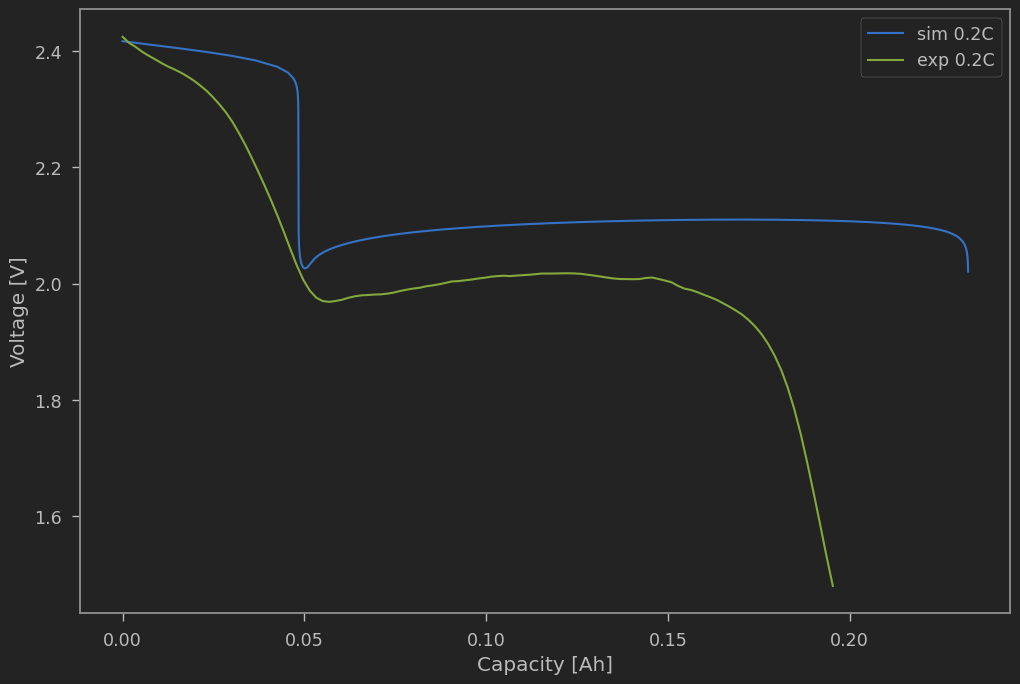

In [128]:
plt.plot(sim_dis.solution.t*0.0422/3600, sim_dis.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.legend(["sim 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

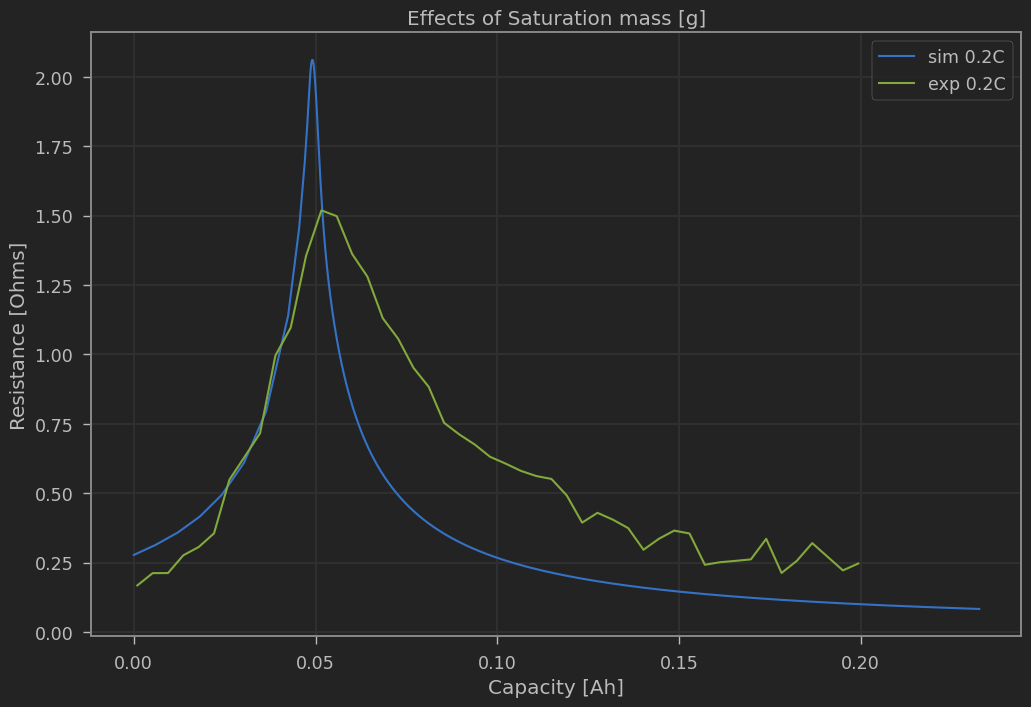

In [129]:
capacity = 2*.0211*sim_dis.solution.t/3600
S4 = sim_dis.solution['S4 [g]'].entries
S2 = sim_dis.solution['S2 [g]'].entries
S1 = sim_dis.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 
R = alpha/(sigma_0-Li)
plt.plot(capacity, R)

filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(res_discharge_data['30'][0],res_discharge_data['30'][1])

#plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)
plt.legend(["sim 0.2C","exp 0.2C" ])

In [130]:
sim_dis_list.append(sim_dis)

In [134]:
# charge IC
loc = 0
S1_initial = sim_cha.solution['S [g]'].entries[loc]
S2_initial = sim_cha.solution['S2 [g]'].entries[loc]
S4_initial = sim_cha.solution['S4 [g]'].entries[loc]
S8_initial = sim_cha.solution['S8 [g]'].entries[loc]
Sp_initial = sim_cha.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_cha.solution['Terminal voltage [V]'].entries[loc]

print(S1_initial)
print(S2_initial)
print(S4_initial)
print(S8_initial)
print(Sp_initial)
print(V_initial)

2.9748920337928233e-05
6.337312856333518e-05
7.433314412095956e-22
1.5316998241186696e-70
0.4440200238458648
2.0221602596769617


In [135]:
# Discharge IC
loc = 0
S1_initial = sim_dis.solution['S [g]'].entries[loc]
S2_initial = sim_dis.solution['S2 [g]'].entries[loc]
S4_initial = sim_dis.solution['S4 [g]'].entries[loc]
S8_initial = sim_dis.solution['S8 [g]'].entries[loc]
Sp_initial = sim_dis.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_dis.solution['Terminal voltage [V]'].entries[loc]

print(S1_initial)
print(S2_initial)
print(S4_initial)
print(S8_initial)
print(Sp_initial)
print(V_initial)

3.4978896460088037e-10
0.21347032345819483
0.21737174533818587
0.00915084712665951
0.004120229621967443
2.416737915314887


Text(0, 0.5, 'Voltage [V]')

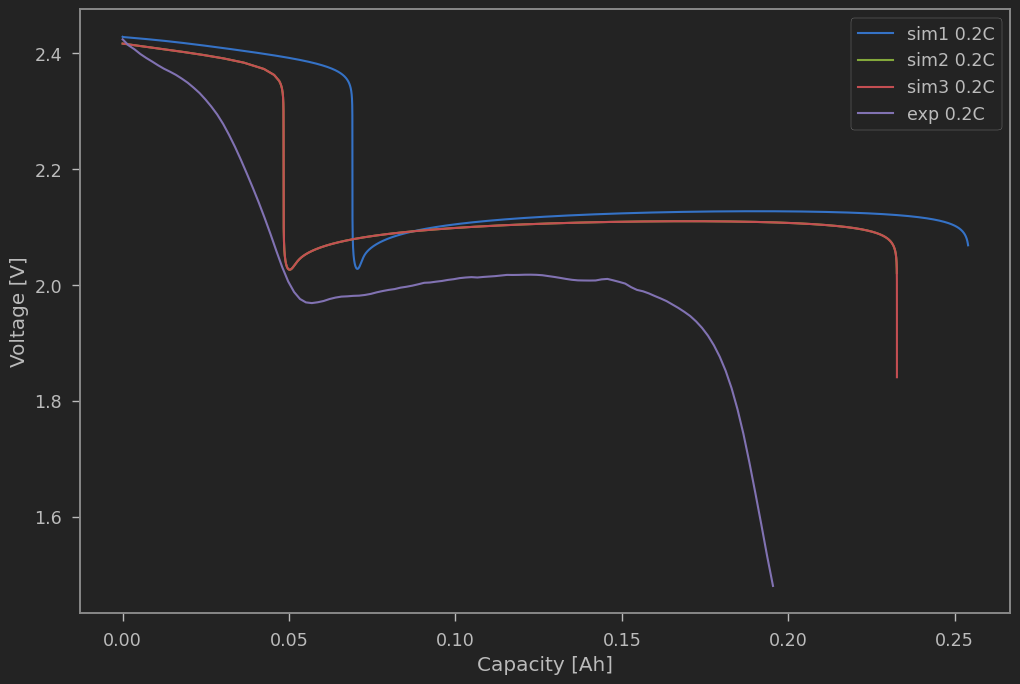

In [153]:
for sim in sim_dis_list:
    plt.plot(sim.solution.t*0.0422/3600, sim.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.legend(["sim1 0.2C","sim2 0.2C","sim3 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

# Cycling settles on single state

# Charge kink test

In [154]:
sim_cha_kink_list = []

## Fullest DoD

In [155]:
loc = -2
S1_initial = sim_dis.solution['S [g]'].entries[loc]
S2_initial = sim_dis.solution['S2 [g]'].entries[loc]
S4_initial = sim_dis.solution['S4 [g]'].entries[loc]
S8_initial = sim_dis.solution['S8 [g]'].entries[loc]
Sp_initial = sim_dis.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_dis.solution['Terminal voltage [V]'].entries[loc]

model_cha_kink = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_cha_kink = model_cha_kink.default_parameter_values
param_cha_kink.update(
    {
        "Current function [A]": -.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        
        }
)


sim_cha_kink = pybamm.Simulation(
    model_cha_kink,
    #experiment=experiment,
    parameter_values = param_cha_kink,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = int(3600*(0.25/0.0211))#.67*7000#16950#3600*hours
for i in range(0,time_in_seconds):
    if i % 1000 == 0 :
           print('\n\n\n\n' + str(100*i/time_in_seconds) + '\n\n\n\n')
    try:
        sim_cha_kink.step(1)
    except:
        break
        
        
print('\n\n\n\n\n\n\n\n\n done')





0.0






psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 9.94274e-05 a

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2.008 and h =

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





2.3444460074084494








4.688892014816899








7.033338022225348








9.377784029633798








11.722230037042246








14.066676044450697








16.411122051859145








18.755568059267596








21.100014066676046








23.444460074084493








25.788906081492943








28.133352088901393








30.477798096309844








32.82224410371829








35.16669011112674








37.51113611853519








39.85558212594364








42.20002813335209








44.544474140760535








46.888920148168985








49.233366155577436








51.577812162985886








53.922258170394336








56.26670417780279








58.61115018521124








60.95559619261969








63.30004220002813








65.64448820743658








67.98893421484503








70.33338022225348








72.67782622966193








75.02227223707038








77.36671824447883








79.71116425188728








82.05561025929573








84.40005626670418








86.74450227411263








89.08894828152107



In [158]:
sim_cha_kink_list.append(sim_cha_kink)

Text(0, 0.5, 'Voltage [V]')

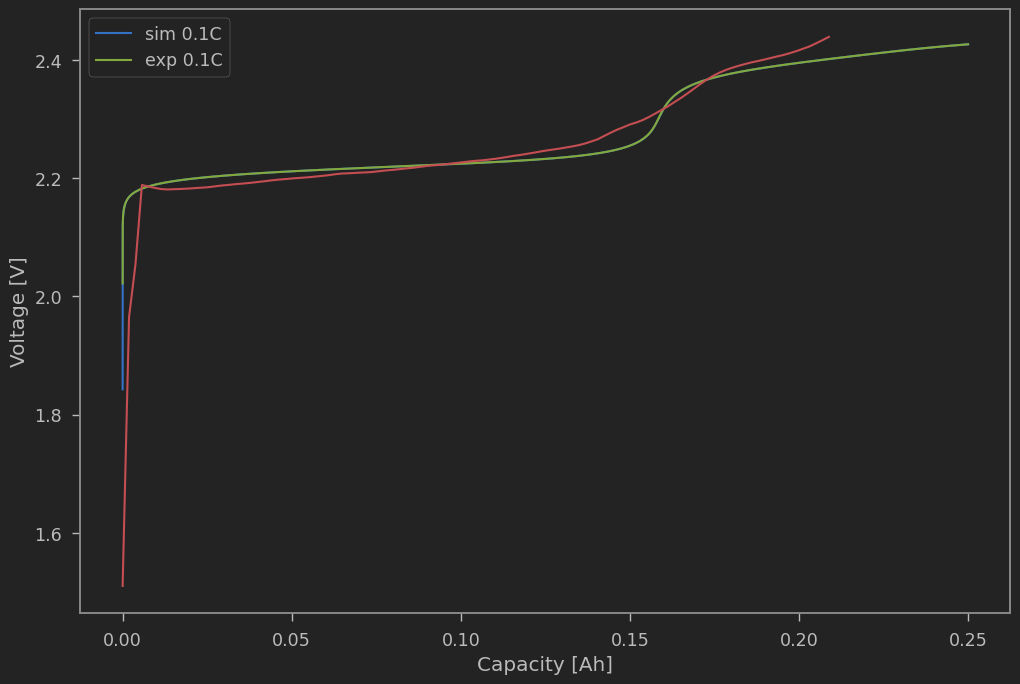

In [157]:
loc = -1
capacity = 0.0211*sim_cha_kink.solution.t[:loc]/3600
V = sim_cha_kink.solution["Terminal voltage [V]"].entries[:loc]
plt.plot(capacity, V)

loc = -1
capacity = 0.0211*sim_cha.solution.t[:loc]/3600
V = sim_cha.solution["Terminal voltage [V]"].entries[:loc]
plt.plot(capacity, V)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C", "exp 0.1C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

In [161]:
loc = -1000
S1_initial = sim_dis.solution['S [g]'].entries[loc]
S2_initial = sim_dis.solution['S2 [g]'].entries[loc]
S4_initial = sim_dis.solution['S4 [g]'].entries[loc]
S8_initial = sim_dis.solution['S8 [g]'].entries[loc]
Sp_initial = sim_dis.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_dis.solution['Terminal voltage [V]'].entries[loc]

V_initial

1.9185405985597705

In [162]:
model_cha_kink = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_cha_kink = model_cha_kink.default_parameter_values
param_cha_kink.update(
    {
        "Current function [A]": -.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        
        }
)


sim_cha_kink = pybamm.Simulation(
    model_cha_kink,
    #experiment=experiment,
    parameter_values = param_cha_kink,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = int(3600*(0.25/0.0211))#.67*7000#16950#3600*hours
for i in range(0,time_in_seconds):
    if i % 1000 == 0 :
           print('\n\n\n\n' + str(100*i/time_in_seconds) + '\n\n\n\n')
    try:
        sim_cha_kink.step(1)
    except:
        break
        
        
print('\n\n\n\n\n\n\n\n\n done')





0.0






psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2.008 and h =

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





2.3444460074084494








4.688892014816899








7.033338022225348








9.377784029633798








11.722230037042246








14.066676044450697








16.411122051859145








18.755568059267596








21.100014066676046








23.444460074084493








25.788906081492943








28.133352088901393








30.477798096309844








32.82224410371829








35.16669011112674








37.51113611853519








39.85558212594364








42.20002813335209








44.544474140760535








46.888920148168985








49.233366155577436








51.577812162985886








53.922258170394336








56.26670417780279








58.61115018521124








60.95559619261969








63.30004220002813








65.64448820743658








67.98893421484503








70.33338022225348








72.67782622966193








75.02227223707038








77.36671824447883








79.71116425188728








82.05561025929573








84.40005626670418








86.74450227411263








89.08894828152107



Text(0, 0.5, 'Voltage [V]')

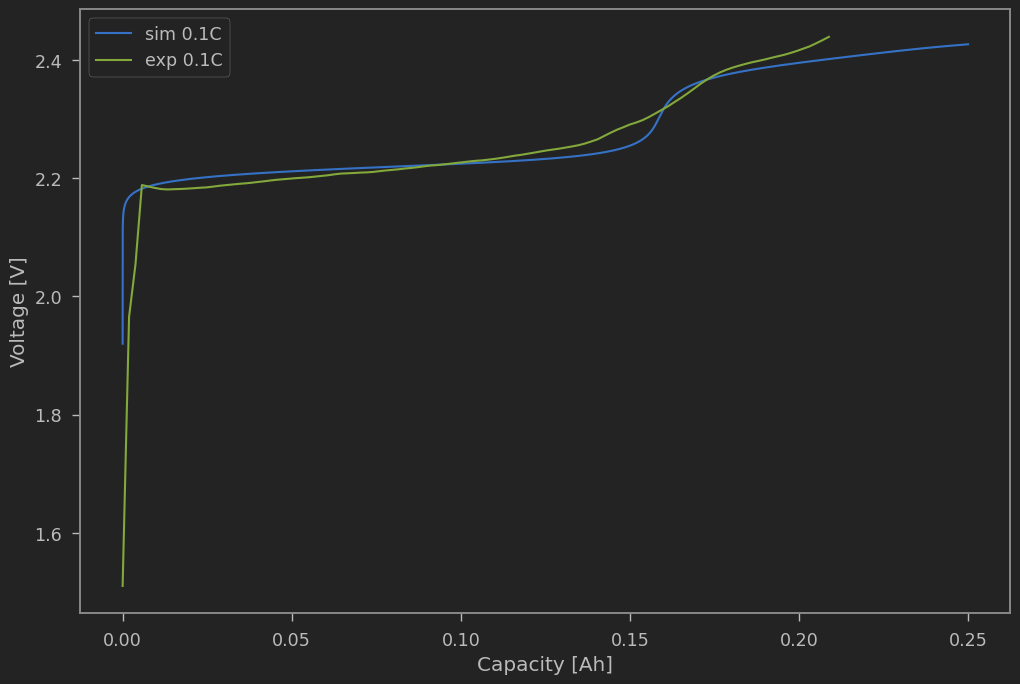

In [163]:
loc = -1
capacity = 0.0211*sim_cha_kink.solution.t[:loc]/3600
V = sim_cha_kink.solution["Terminal voltage [V]"].entries[:loc]
plt.plot(capacity, V)


# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C", "exp 0.1C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

In [164]:
sim_cha_kink_list.append(sim_cha_kink)

Text(0, 0.5, 'Voltage [V]')

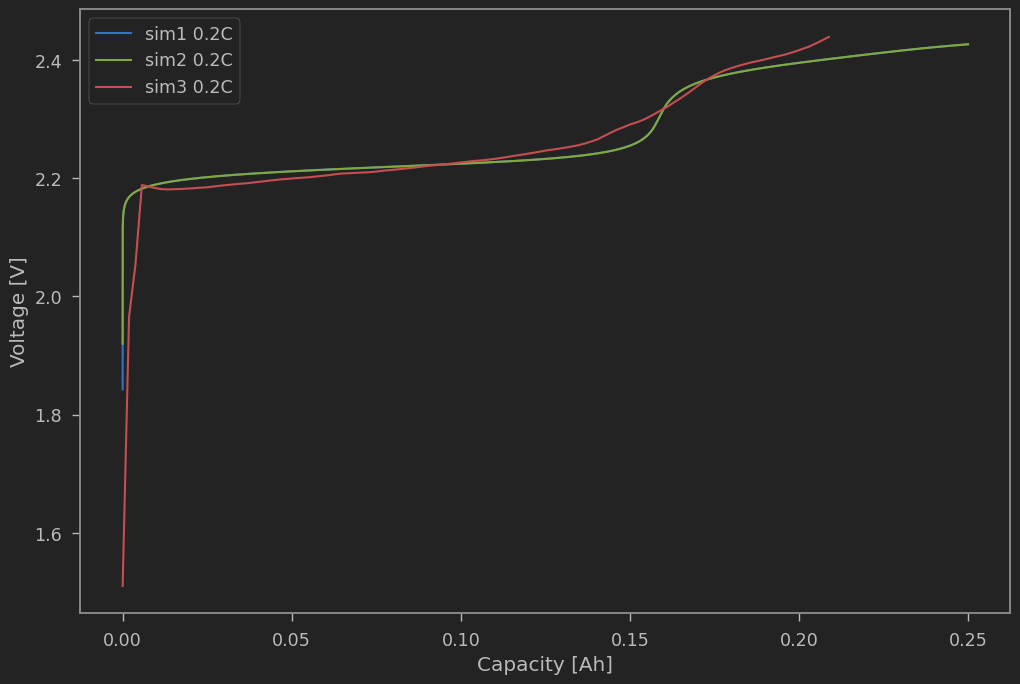

In [166]:
for sim in sim_cha_kink_list:
    plt.plot(sim.solution.t*0.0211/3600, sim.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim1 0.2C","sim2 0.2C","sim3 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

## Conclusion: Fail

# Infinite Voltage/Capacity Test

In [192]:
loc = -10
S1_initial = sim_dis.solution['S [g]'].entries[loc]
S2_initial = sim_dis.solution['S2 [g]'].entries[loc]
S4_initial = sim_dis.solution['S4 [g]'].entries[loc]
S8_initial = sim_dis.solution['S8 [g]'].entries[loc]
Sp_initial = sim_dis.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_dis.solution['Terminal voltage [V]'].entries[loc]

V_initial

1.845809454330479

In [195]:
model_cha_high_c = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_cha_high_c = model_cha_high_c.default_parameter_values
param_cha_high_c.update(
    {
        "Current function [A]": -2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        
        }
)


sim_cha_high_c = pybamm.Simulation(
    model_cha_high_c,
    #experiment=experiment,
    parameter_values = param_cha_high_c,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time = 0
while time <= 10:
    sim_cha_high_c.step(0.01)
    time += 0.01
print('\n\n\n\n\n\n\n\n\n FIRST done')
time_in_seconds = int(3600*(0.35*0.5/0.0211))#.67*7000#16950#3600*hours

while time < time_in_seconds:
    if round(time)  % 1000 == 0 :
           print('\n\n\n\n' + str(100*time/time_in_seconds) + '\n\n\n\n')
    try:
        sim_cha_high_c.step(1)
        time +=1
    except:
        break
        
        
print('\n\n\n\n\n\n\n\n\n done')

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 6.82552e-05 a

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c










 FIRST done




3.3493318149847595








6.6986301369863








10.047928458987842








13.397226780989383








16.746525102990923








20.095823424992464








23.445121746994005








26.794420068995546








30.143718390997087








33.493016712998624








36.84231503500017








40.19161335700171








43.54091167900325








46.89021000100479








50.23950832300633








53.58880664500787








56.93810496700942








60.28740328901096








63.6367016110125








66.98599993301404








70.33529825501557








73.68459657701712








77.03389489901866








80.38319322102019








83.73249154302174








87.08178986502328








90.43108818702481








93.78038650902636








97.1296848310279













 done


Text(0, 0.5, 'Voltage [V]')

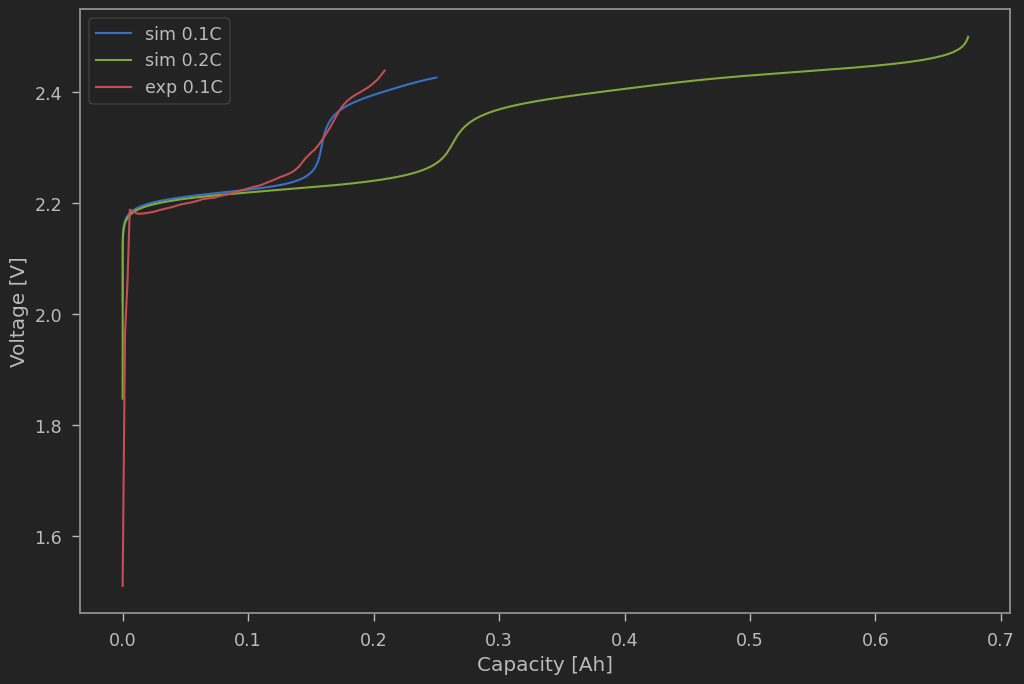

In [196]:
loc = -1
capacity = 0.0211*sim_cha.solution.t[:loc]/3600
V = sim_cha.solution["Terminal voltage [V]"].entries[:loc]
plt.plot(capacity, V)

capacity = 4*0.0211*sim_cha_high_c.solution.t[:loc]/3600
V = sim_cha_high_c.solution["Terminal voltage [V]"].entries[:loc]
plt.plot(capacity, V)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C","sim 0.2C", "exp 0.1C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

In [12]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = int(.24*3600/0.0211)#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        print("Time's up!")
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    elif sim.solution['Terminal voltage [V]'].entries[-1] > 2.49:
        print('High Voltage!')
        return True
    else:
        return False

    
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 500 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha1) or time_check(sim_cha1) or voltage_check(sim_cha1):
            break_condition = False
        else:
            sim_cha1.step(500)
    except:
        condition = False
        
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha1) or time_check(sim_cha1) or voltage_check(sim_cha1):
            break_condition = False
        else:
            sim_cha1.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha1) or time_check(sim_cha1) or voltage_check(sim_cha1):
            break_condition = False
        else:
            sim_cha1.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha1) or time_check(sim_cha1) or voltage_check(sim_cha1):
            break_condition = False
        else:
            sim_cha1.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha1) or time_check(sim_cha1) or voltage_check(sim_cha1):
            break_condition = False
        else:
            sim_cha1.step(1)
    except:
        condition = False






 Trying 500 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Time's up!





 Trying 100 





Time's up!





 Trying 50 










 Trying 10 










 Trying 1 







Text(0, 0.5, 'Voltage [V]')

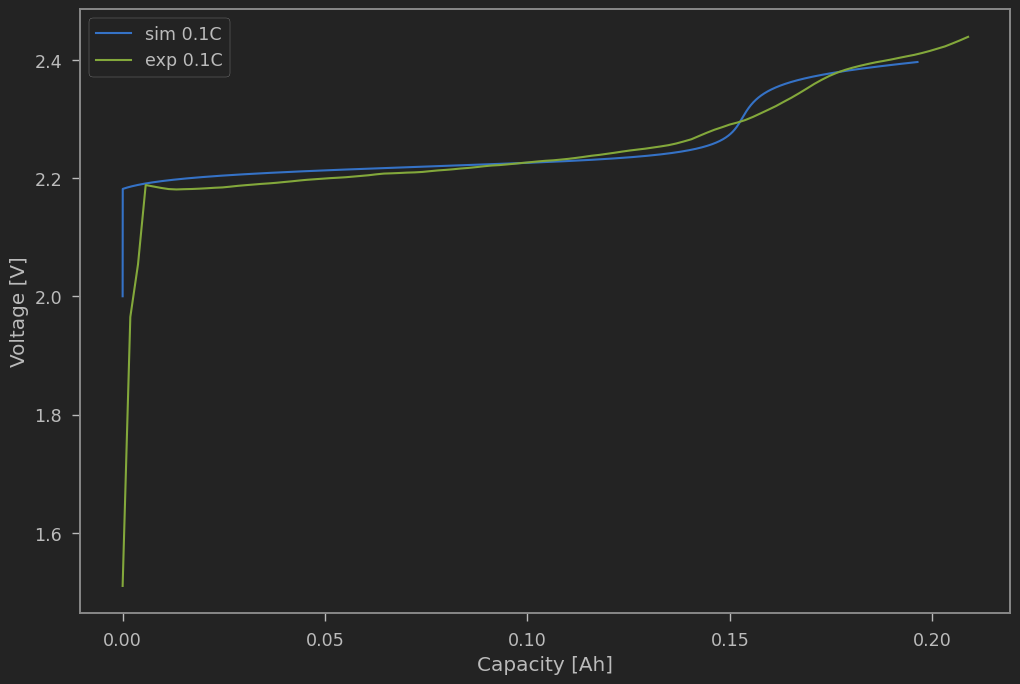

In [50]:
loc = -1
capacity = 0.0211*sim_cha1.solution.t[:loc]/3600
V = sim_cha1.solution["Terminal voltage [V]"].entries[:loc]
plt.plot(capacity, V)


# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C", "exp 0.1C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

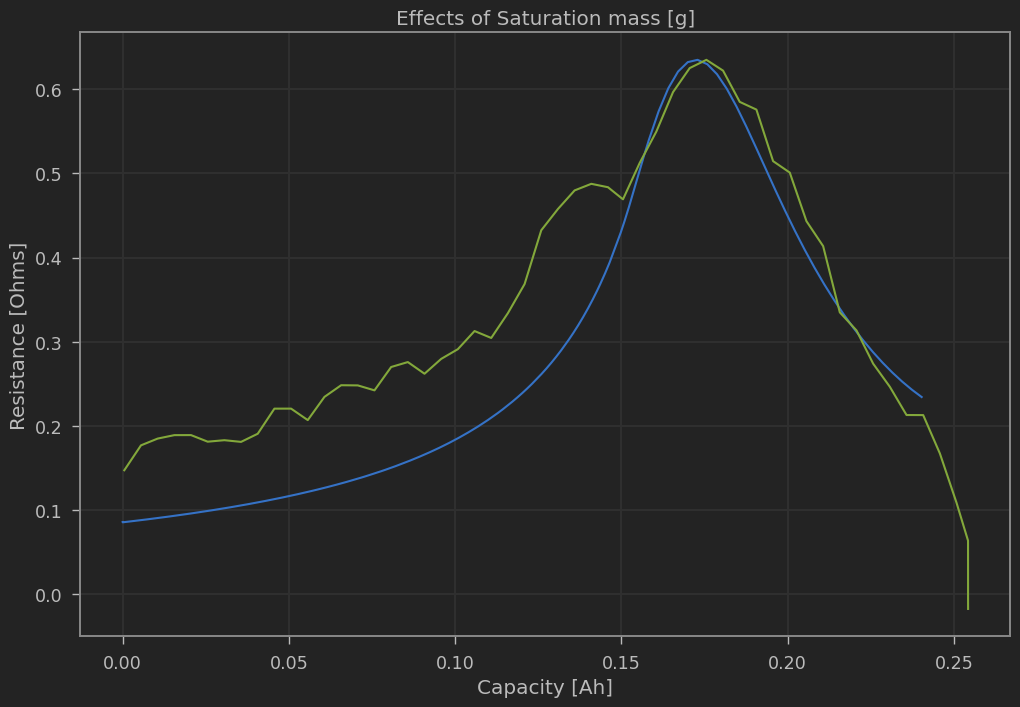

In [16]:
capacity = .0211*sim_cha1.solution.t/3600
S4 = sim_cha1.solution['S4 [g]'].entries
S2 = sim_cha1.solution['S2 [g]'].entries
S1 = sim_cha1.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 

filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

sigma_0 = max(Li)*1.15
R = 1/(sigma_0-Li)
alpha = max(res_charge_data['30'][1])/max(R)
R *= alpha

plt.plot(capacity,R)

plt.plot(res_charge_data['30'][0],res_charge_data['30'][1])

#plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)

In [48]:
loc = -1
S1_initial = sim_cha1.solution['S [g]'].entries[loc]
S2_initial = sim_cha1.solution['S2 [g]'].entries[loc]
S4_initial = sim_cha1.solution['S4 [g]'].entries[loc]
S8_initial = sim_cha1.solution['S8 [g]'].entries[loc]
Sp_initial = sim_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_cha1.solution['Terminal voltage [V]'].entries[loc]
cap_temp = sim_cha1.solution.t[loc]*0.0221/3600
print(S8_initial)
print(S4_initial)
print(S2_initial)
print(S1_initial)
print(Sp_initial)
print(V_initial)
print(cap_temp)

0.02115052355649982
0.23484421453453067
0.18529953741324415
2.7328540809557687e-10
0.0028188701171487623
2.4220069619424405
0.248625


In [44]:
model_dis1 = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_dis1 = model_dis1.default_parameter_values
param_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        #'Shuttle rate coefficient during charge [s-1]': 0.00001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 100,
        #'Reference Temperature [K]': 298
        
        }
)



experiment = pybamm.Experiment(
    [
        ("Discharge at 0.0422 A for 2 hours or until 2.0 V"),
    ] 
)


sim_dis1 = pybamm.Simulation(
    model_dis1,
    #experiment=experiment,
    parameter_values = param_dis1,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8

time_in_seconds = 10000#int(3600/(2*0.0211))#3875#3840#.67*7000#16950#3600*hours
for i in range(0,time_in_seconds):
    try:
        sim_dis1.step(1)
    except:
        break
        
print('\n\n\n\n\n\n\n\n\n done')

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

done


In [40]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = 19735#int(.24*3600/0.0422)#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        print("Time's up!")
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    elif sim.solution['Terminal voltage [V]'].entries[-1] > 2.49:
        print('High Voltage!')
        return True
    else:
        return False

    
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 500 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis1) or time_check(sim_dis1) or voltage_check(sim_dis1):
            break_condition = False
        else:
            sim_dis1.step(500)
    except:
        condition = False
        
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis1) or time_check(sim_dis1) or voltage_check(sim_dis1):
            break_condition = False
        else:
            sim_dis1.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis1) or time_check(sim_dis1) or voltage_check(sim_dis1):
            break_condition = False
        else:
            sim_dis1.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis1) or time_check(sim_dis1) or voltage_check(sim_dis1):
            break_condition = False
        else:
            sim_dis1.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis1) or time_check(sim_dis1) or voltage_check(sim_dis1):
            break_condition = False
        else:
            sim_dis1.step(1)
    except:
        condition = False






 Trying 500 





Negative Species Values!
-2.5063729247809073e-17
0.00015276224845195416
0.4372764089774054
4.089502337859845e-08
0.00668393377382748





 Trying 100 





Negative Species Values!
-2.5063729247809073e-17
0.00015276224845195416
0.4372764089774054
4.089502337859845e-08
0.00668393377382748





 Trying 50 










 Trying 10 










 Trying 1 







Text(0, 0.5, 'Voltage [V]')

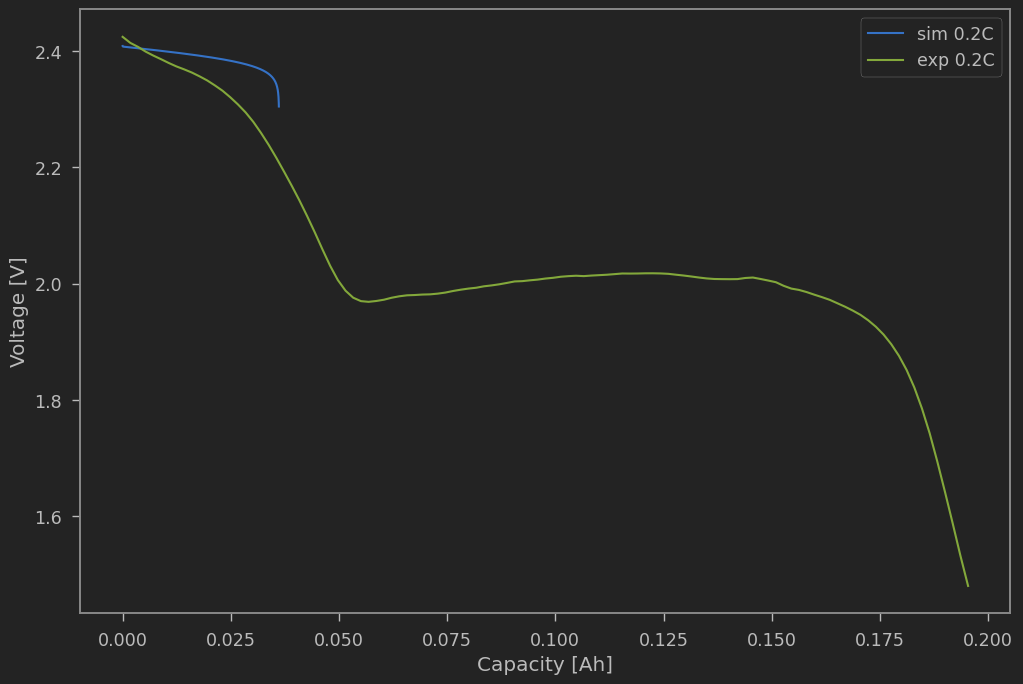

In [41]:
plt.plot(sim_dis1.solution.t*0.0422/3600, sim_dis1.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.legend(["sim 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

In [ ]:
capacity = 2*.0211*sim_dis1.solution.t/3600
S4 = sim_dis1.solution['S4 [g]'].entries
S2 = sim_dis1.solution['S2 [g]'].entries
S1 = sim_dis1.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 
R = alpha/(sigma_0-Li)
plt.plot(capacity, R)

filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(res_discharge_data['30'][0],res_discharge_data['30'][1])

#plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)
plt.legend(["sim 0.2C","exp 0.2C" ])

In [82]:
def charge(sim_dis):
    # get IC
    loc = -1
    S1_initial = sim_dis.solution['S [g]'].entries[loc]
    S2_initial = sim_dis.solution['S2 [g]'].entries[loc]
    S4_initial = sim_dis.solution['S4 [g]'].entries[loc]
    S8_initial = sim_dis.solution['S8 [g]'].entries[loc]
    Sp_initial = sim_dis.solution['Precipitated Sulfur [g]'].entries[loc]
    V_initial = sim_dis.solution['Terminal voltage [V]'].entries[loc]
    
    # set up model
    model_cha = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

    param_cha = model_cha.default_parameter_values
    param_cha.update(
        {
            "Current function [A]": -.0211,
            "Initial Condition for Terminal Voltage [V]": V_initial,
            "Initial Condition for S8 ion [g]" : S8_initial,
            "Initial Condition for S4 ion [g]" : S4_initial,
            "Initial Condition for S2 ion [g]" : S2_initial,
            "Initial Condition for S ion [g]" : S1_initial,
            "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
            "Lower voltage cut-off [V]" : 1.2,
            "Upper voltage cut-off [V]" : 2.5,
            "Standard Potential L [V]" : EL0,
            "Standard Potential M [V]" : EM0,
            "Standard Potential H [V]" : EH0,
            "Exchange current density L [A.m-2]": il0,
            "Exchange current density M [A.m-2]": im0,
            "Exchange current density H [A.m-2]": ih0,
            "Active reaction area per cell [m2]":ar,
            "S saturation mass [g]": S_star,#*.0145,
            'gamma': 0,#10e1,#10,#10e40,#10,
            'kappa': 0,#10e10,#10e28,#10e80,
            #'Shuttle rate coefficient during charge [s-1]': 0.00001,
            'Shuttle rate coefficient during discharge [s-1]': 0,
            'Precipitation rate [s-1]': 5000,
            #'Reference Temperature [K]': 298

            }
    )


    sim_cha = pybamm.Simulation(
        model_cha,
        #experiment=experiment,
        parameter_values = param_cha,
        solver=pybamm.CasadiSolver(
            atol=1e-8,
            rtol=1e-6,
            dt_max = .01,
            extra_options_setup={"max_step_size": 0.1}, 
            max_step_decrease_count = 15,
        ),
    )
    
    # simulate 
    time_in_seconds = int(3600/0.1)+3400#3875#3840#.67*7000#16950#3600*hours
    for i in range(0,time_in_seconds):
        if i % 1000 == 0:
            print('\n\n\n\n')
            print(100*i/time_in_seconds)
            print('\n\n\n\n')
        sim_cha.step(1)
    return sim_cha

def discharge(sim_cha,step_size):
    # get IC
    loc = -1
    S1_initial = sim_cha.solution['S [g]'].entries[loc]
    S2_initial = sim_cha.solution['S2 [g]'].entries[loc]
    S4_initial = sim_cha.solution['S4 [g]'].entries[loc]
    S8_initial = sim_cha.solution['S8 [g]'].entries[loc]
    Sp_initial = sim_cha.solution['Precipitated Sulfur [g]'].entries[loc]
    V_initial = sim_cha.solution['Terminal voltage [V]'].entries[loc]
    
    # set up model
    model_dis = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

    param_dis = model_dis.default_parameter_values
    param_dis.update(
        {
            "Current function [A]": 2*.0211,
            "Initial Condition for Terminal Voltage [V]": V_initial,
            "Initial Condition for S8 ion [g]" : S8_initial,
            "Initial Condition for S4 ion [g]" : S4_initial,
            "Initial Condition for S2 ion [g]" : S2_initial,
            "Initial Condition for S ion [g]" : S1_initial,
            "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
            "Lower voltage cut-off [V]" : 1.2,
            "Upper voltage cut-off [V]" : 2.5,
            "Standard Potential L [V]" : EL0,
            "Standard Potential M [V]" : EM0,
            "Standard Potential H [V]" : EH0,
            "Exchange current density L [A.m-2]": il0,
            "Exchange current density M [A.m-2]": im0,
            "Exchange current density H [A.m-2]": ih0,
            "Active reaction area per cell [m2]":ar,
            "S saturation mass [g]": S_star,#*.0145,
            'gamma': 0,#10e1,#10,#10e40,#10,
            'kappa': 0,#10e10,#10e28,#10e80,
            #'Shuttle rate coefficient during charge [s-1]': 0.00001,
            'Shuttle rate coefficient during discharge [s-1]': 0,
            'Precipitation rate [s-1]': 100,
            #'Reference Temperature [K]': 298

            }
    )


    sim_dis = pybamm.Simulation(
        model_dis,
        #experiment=experiment,
        parameter_values = param_dis,
        solver=pybamm.CasadiSolver(
            atol=1e-8,
            rtol=1e-6,
            dt_max = .01,
            extra_options_setup={"max_step_size": 0.1}, 
            max_step_decrease_count = 15,
        ),
    )
    
    # simulate 
    time_in_seconds = int(3600/.2)+3400#3875#3840#.67*7000#16950#3600*hours
    for i in range(0,int(time_in_seconds/step_size)):
        if i % 1000 == 0:
            print('\n\n\n\n')
            print(100*i/time_in_seconds)
            print('\n\n\n\n')
        try:
            sim_dis.step(step_size)
        except:
            try:
                sim_dis(500)
            except:
                break
    return sim_dis

In [49]:
sim_cha2 = charge(sim_dis1)






0.0







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed







2.5380710659898478










5.0761421319796955










7.614213197969543










10.152284263959391










12.690355329949238










15.228426395939087










17.766497461928935










20.304568527918782










22.84263959390863










25.380710659898476










27.918781725888326










30.456852791878173










32.994923857868024










35.53299492385787










38.07106598984772










40.609137055837564










43.14720812182741










45.68527918781726










48.223350253807105










50.76142131979695










53.2994923857868










55.83756345177665










58.3756345177665










60.91370558375635










63.45177664974619










65.98984771573605










68.52791878172589










71.06598984771574










73.60406091370558










76.14213197969544










78.68020304568527










81.21827411167513










83.75634517766497










86.29441624365482










88.83248730964468










91.3

Text(0, 0.5, 'Voltage [V]')

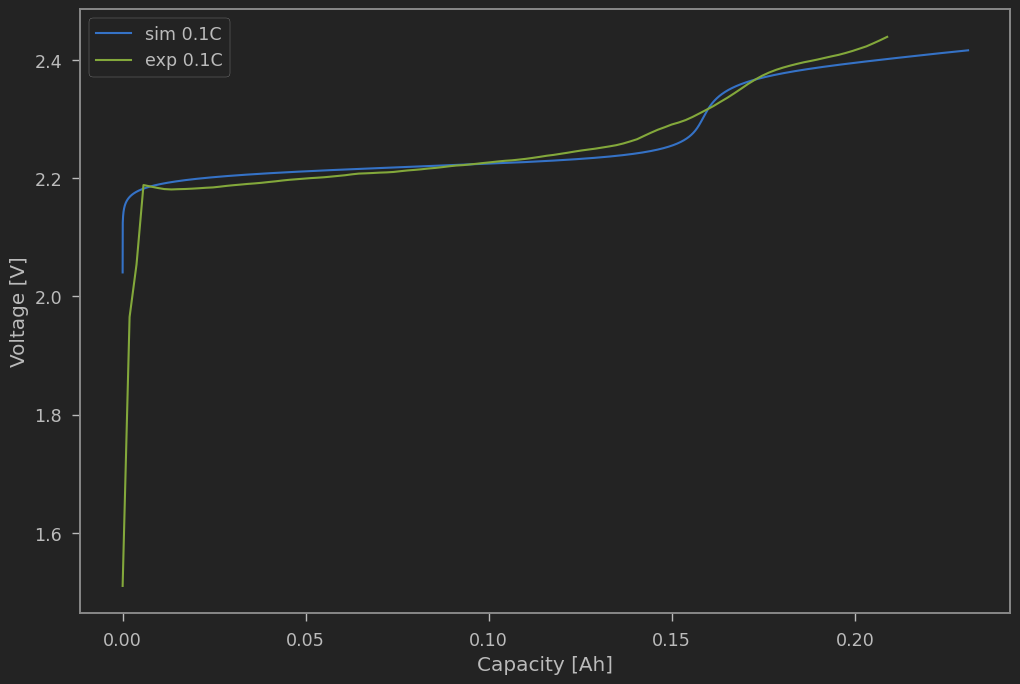

In [50]:
capacity = 0.0211*sim_cha2.solution.t/3600
V = sim_cha2.solution["Terminal voltage [V]"].entries
plt.plot(capacity, V)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C", "exp 0.1C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

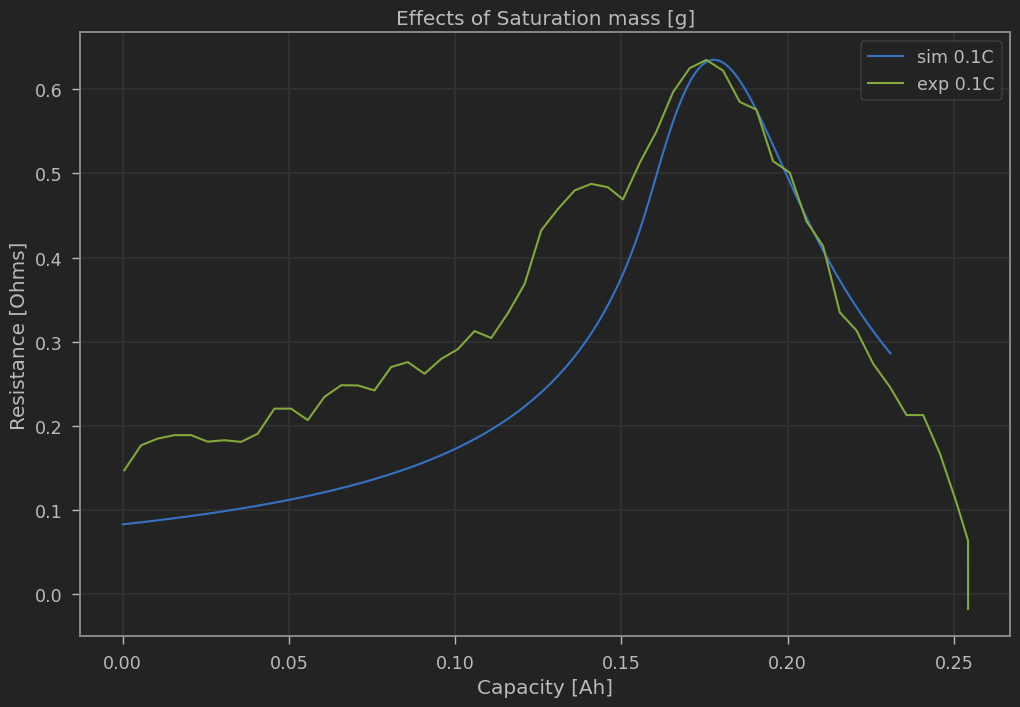

In [51]:


capacity = .0211*sim_cha2.solution.t/3600
S4 = sim_cha2.solution['S4 [g]'].entries
S2 = sim_cha2.solution['S2 [g]'].entries
S1 = sim_cha2.solution['S [g]'].entries
Li_cha2 = S1 + 0.5*S2 + 0.25*S4 
b = 8e-2
sigma = sigma_0 - b*(Li_cha2)
R_cha2 = l/(A*sigma)
#plt.plot(capacity,R)
R_cha2 = 1/(max(Li_cha)*1.15-Li_cha2)


filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(sim_cha2.solution.t*0.0211/3600,max(res_charge_data['30'][1])*R_cha2/max(R_cha))

plt.plot(res_charge_data['30'][0],res_charge_data['30'][1])

#plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)
plt.legend(["sim 0.1C","exp 0.1C" ])

In [64]:
sim_dis2 = discharge(sim_cha2,10)






0.0







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 3908.87 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 3991.57 and h = 9.53674e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






4.672897196261682







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19623.5 and h = 4.76837e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Text(0, 0.5, 'Voltage [V]')

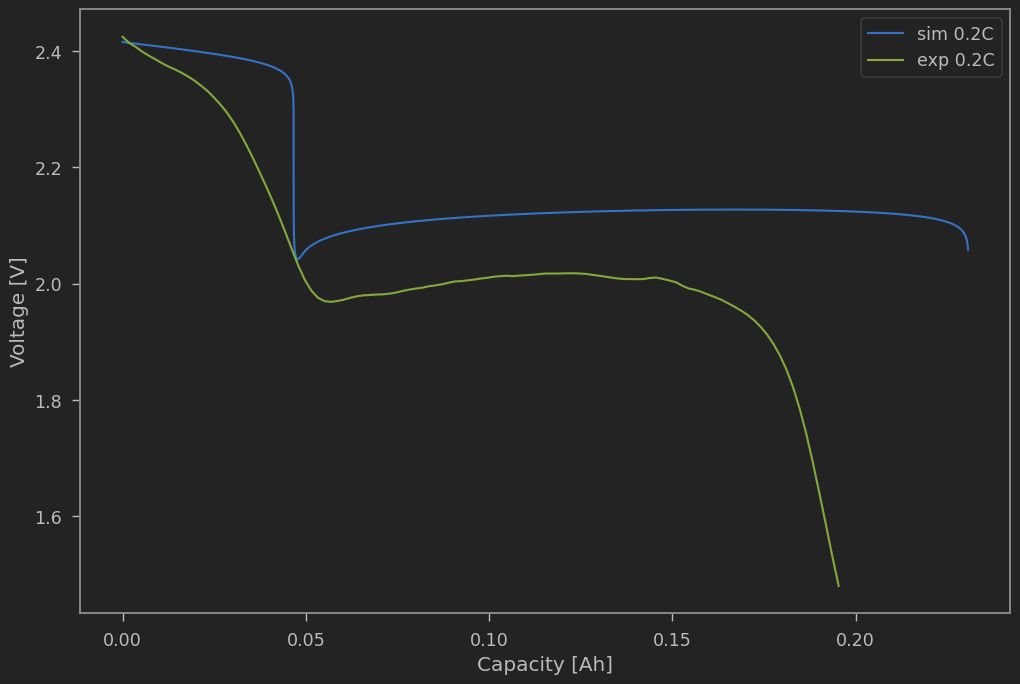

In [65]:
plt.plot(sim_dis2.solution.t*0.0422/3600, sim_dis2.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.legend(["sim 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

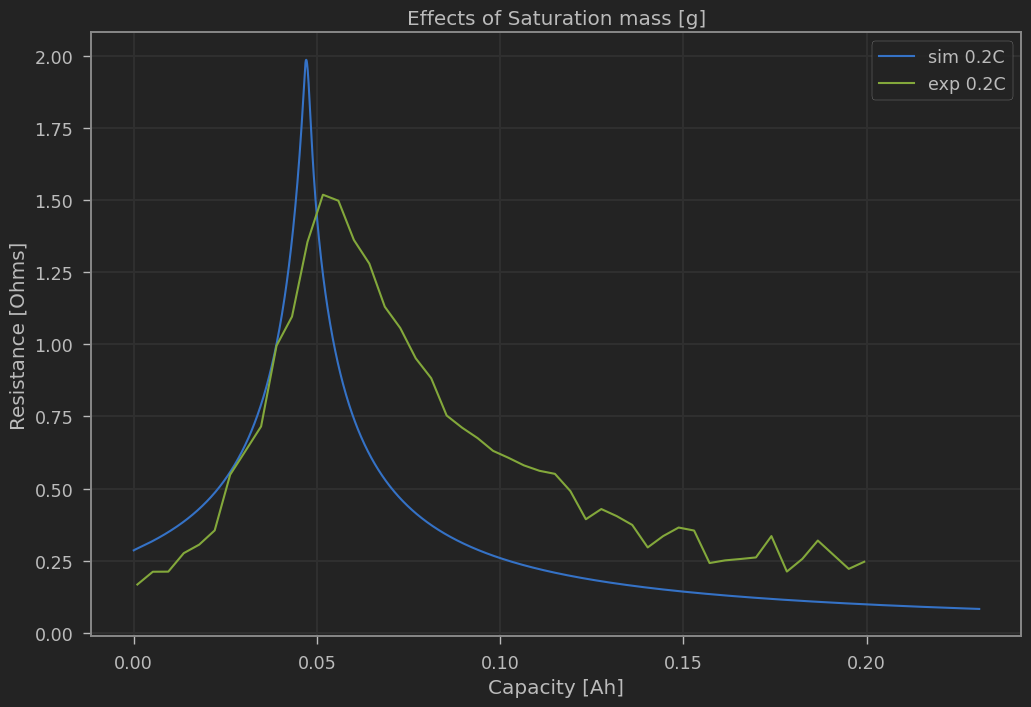

In [67]:
sigma_0 = 2e-2
l =  4e-5
A = 0.15

capacity = .0211*sim_dis2.solution.t/3600
S4 = sim_dis2.solution['S4 [g]'].entries
S2 = sim_dis2.solution['S2 [g]'].entries
S1 = sim_dis2.solution['S [g]'].entries
Li_dis2 = S1 + 0.5*S2 + 0.25*S4 
b = 8e-2
sigma = sigma_0 - b*(Li_dis2)
R_dis2 = l/(A*sigma)
#plt.plot(capacity,R)
R_dis2 = 1/(max(Li_cha)*1.15-Li_dis2)


filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(sim_dis2.solution.t*0.0422/3600,max(res_charge_data['30'][1])*R_dis2/max(R_cha))

plt.plot(res_discharge_data['30'][0],res_discharge_data['30'][1])

#plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)
plt.legend(["sim 0.2C","exp 0.2C" ])

In [74]:
sim_dis_list = [sim_dis1, sim_dis2]
sim_cha_list = [sim_cha1, sim_cha2]


sim_dis = sim_dis_list[-1]
sim_cha = charge(sim_dis)
sim_cha_list.append(sim_cha)







0.0










2.5380710659898478










5.0761421319796955










7.614213197969543










10.152284263959391










12.690355329949238










15.228426395939087










17.766497461928935










20.304568527918782










22.84263959390863










25.380710659898476










27.918781725888326










30.456852791878173










32.994923857868024










35.53299492385787










38.07106598984772










40.609137055837564










43.14720812182741










45.68527918781726










48.223350253807105










50.76142131979695










53.2994923857868










55.83756345177665










58.3756345177665










60.91370558375635










63.45177664974619










65.98984771573605










68.52791878172589










71.06598984771574










73.60406091370558










76.14213197969544










78.68020304568527










81.21827411167513










83.75634517766497










86.29441624365482










88.83248730964468


In [84]:
sim_dis = discharge(sim_cha,1000)






0.0







At t = 999.008, , mxstep steps taken before reaching tout.
At t = 1999.43, , mxstep steps taken before reaching tout.
At t = 2999.44, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/su

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 3987.32 and h = 9.40636e-10, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 5033.14 and h = 4.76837e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 13412.3 and h = 9.53674e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 16197.4 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [85]:
sim_dis_list.append(sim_dis)

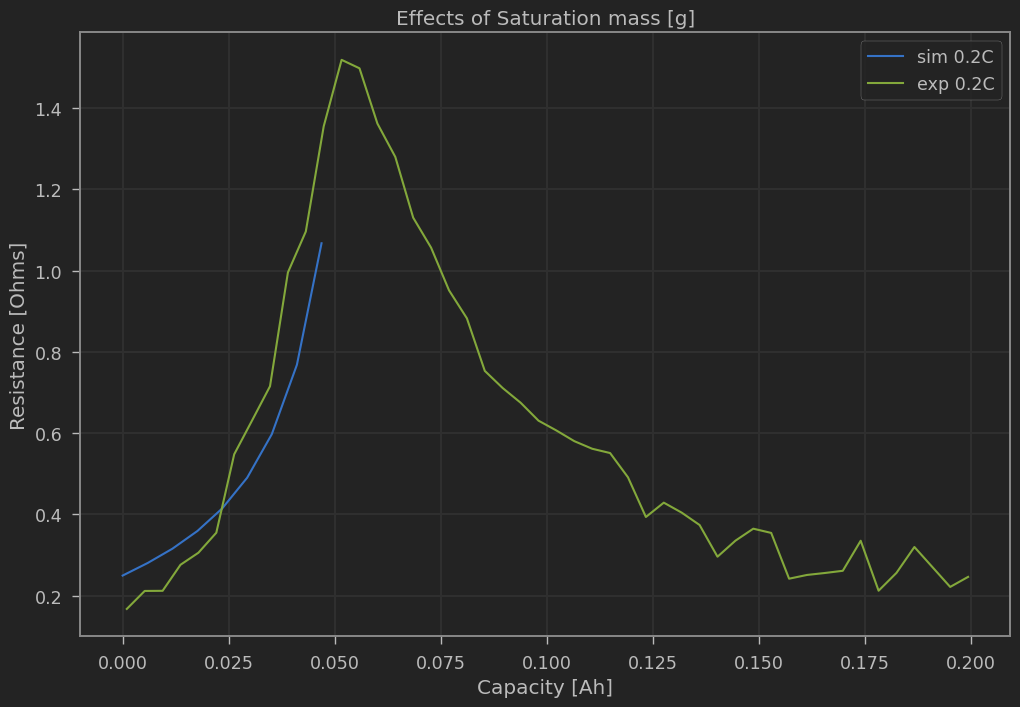

In [99]:
sim_dis = sim_dis_list[-1]
sigma_0 = 2e-2
l =  4e-5
A = 0.15

capacity = .0211*sim_dis.solution.t/3600
S4 = sim_dis.solution['S4 [g]'].entries
S2 = sim_dis.solution['S2 [g]'].entries
S1 = sim_dis.solution['S [g]'].entries
Li_dis = S1 + 0.5*S2 + 0.25*S4 
b = 8e-2
sigma = sigma_0 - b*(Li_dis)
R_dis = l/(A*sigma)
#plt.plot(capacity,R)
R_dis = 1/(max(Li_cha)*1.15-Li_dis)


filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
#filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(sim_dis.solution.t*0.0422/3600,max(res_charge_data['30'][1])*R_dis/max(R_cha))

plt.plot(res_discharge_data['30'][0],res_discharge_data['30'][1])

#plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)
plt.legend(["sim 0.2C","exp 0.2C" ])

In [87]:
n = 3
while n > 0:
    sim_dis = sim_dis_list[-1]
    sim_cha = charge(sim_dis)
    sim_cha_list.append(sim_cha)
    
    sim_dis = discharge(sim_cha,1000)
    sim_dis_list.append(sim_dis)
    
    n -= 1






0.0







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






2.5380710659898478










5.0761421319796955










7.614213197969543










10.152284263959391










12.690355329949238










15.228426395939087










17.766497461928935










20.304568527918782










22.84263959390863










25.380710659898476










27.918781725888326










30.456852791878173










32.994923857868024










35.53299492385787










38.07106598984772










40.609137055837564










43.14720812182741










45.68527918781726










48.223350253807105










50.76142131979695










53.2994923857868










55.83756345177665










58.3756345177665










60.91370558375635










63.45177664974619










65.98984771573605










68.52791878172589










71.06598984771574










73.60406091370558










76.14213197969544










78.68020304568527










81.21827411167513










83.75634517766497










86.29441624365482










88.83248730964468










91.3

At t = 999.223, , mxstep steps taken before reaching tout.
At t = 1999.41, , mxstep steps taken before reaching tout.
At t = 2999.46, , mxstep steps taken before reaching tout.
At t = 3999.43, , mxstep steps taken before reaching tout.
At t = 4548.93 and h = 9.53674e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calcul






0.0










2.5380710659898478










5.0761421319796955










7.614213197969543










10.152284263959391










12.690355329949238







KeyboardInterrupt: 

In [97]:
sim_dis = discharge(sim_cha,500)






0.0







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4547.3 and h 

In [101]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = 19735#int(.24*3600/0.0422)#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        print("Time's up!")
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    elif sim.solution['Terminal voltage [V]'].entries[-1] > 2.49:
        print('High Voltage!')
        return True
    else:
        return False

    
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 500 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis) or time_check(sim_dis) or voltage_check(sim_dis):
            break_condition = False
        else:
            sim_dis.step(500)
    except:
        condition = False
        
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis) or time_check(sim_dis) or voltage_check(sim_dis):
            break_condition = False
        else:
            sim_dis.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis) or time_check(sim_dis) or voltage_check(sim_dis):
            break_condition = False
        else:
            sim_dis.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis) or time_check(sim_dis) or voltage_check(sim_dis):
            break_condition = False
        else:
            sim_dis.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis) or time_check(sim_dis) or voltage_check(sim_dis):
            break_condition = False
        else:
            sim_dis.step(1)
    except:
        condition = False






 Trying 500 










 Trying 100 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4613.64 and h






 Trying 50 










 Trying 10 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






 Trying 1 





Negative Species Values!
-3.677054950927453e-19
4.9693623423488993e-05
0.4408862186475222
7.258037393040465e-08
0.003177161043131768


.../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4611.26 and h = 7.45058e-10,

In [ ]:
sim_dis_list.append(sim_dis)